In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

from blockchain import util
util.TIMEOUT = 20

In [2]:
from blockchain import blockexplorer
from blockutils import BlockUtils
import numpy as np 
from matplotlib import pyplot as plt
from scipy.stats import variation
from scipy.stats import zscore
from scipy.stats import iqr

In [3]:
#latest = blockexplorer.get_block(blockexplorer.get_latest_block().hash)
#latest = blockexplorer.get_block("0000000000000000000857fad93ae6e401153a94f06c4b5adfb733f20a6c13b1")

In [4]:
#Downloads and writes n blocks from the given block to disk
#fromBlocks - hash of a highest block 
def fetch_blocks(fromBlock,n):
    butils = BlockUtils()
    butils.clear()
    status = butils.writeBlock(fromBlock.json)
    blocks = [fromBlock]
    prev = []
    prevHash = None
    for i in range(0,50):
        prevHash=blocks[0].previous_block
        b = blockexplorer.get_block(prevHash)
        blocks.insert(0,b)
        status = vbutils.writeBlock(b.json)
        prev = b.previous_block
    #return blocks

In [5]:
#load blocks for disk
butils = BlockUtils()
blocks = butils.getBlock()

In [6]:
txs=[block.transactions for block in blocks]

In [7]:
#alt[0] ----> neu[-1]
#transaction data
times=[]
for alltx in txs:
    times.append([tx.time for tx in alltx])
sizes = []
for alltx in txs:
    sizes.append([tx.size for tx in alltx])
fees = []
for alltx in txs:
    fees.append([tx.fee for tx in alltx])

In [8]:
npSizes = np.array(sizes)
npSizes.shape
npFees = np.array(fees)
npSizes.shape
pricePerByte = [np.divide(npFees[i],npSizes[i]) for i in range(0,len(npFees))]

(51,)

(51,)

In [11]:
iqrFees = [iqr(pricePerByte[i]) for i in range(0,len(pricePerByte))]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [13]:
iqrFees=np.array(iqrFees)
iqrFees = iqrFees.reshape(-1, 1)
y_train, y_test = train_test_split(iqrFees, test_size=0.3, random_state=0)
x_train = np.array(list(range(0,len(y_train)))).reshape(-1,1)
x_test = np.array(list(range(0,len(y_test)))).reshape(-1,1)

In [14]:
degree=1
linReg=make_pipeline(PolynomialFeatures(degree),LinearRegression());
linReg.fit(x_train,y_train);
linReg.score(x_test,y_test);

In [15]:
yPred = linReg.predict(np.array(list(range(0,len(iqrFees)+1))).reshape(-1,1))

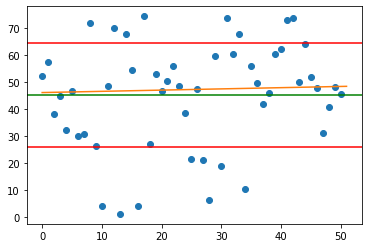

In [16]:
plt.plot(iqrFees,'o')
#plt.plot(maxfee)
#plt.plot(minfee)
plt.plot(yPred);
meanp=np.mean(iqrFees);
plt.axhline(y=meanp,color='g')
stdp = np.std(iqrFees);
plt.axhline(y=meanp+stdp,color='r');
plt.axhline(y=meanp-stdp,color='r');

In [17]:
#prediction for next block
yPred[-1]

array([48.4875156])

In [20]:
#Block stuff

In [21]:
#last 50block mean fees
medfee = [np.median(fees) for fees in feesRaw]
iqrfee = [iqr(fees,axis=0) for fees in feesRaw]
maxfee = [np.max(fees) for fees in feesRaw]
minfee = [np.min(fees) for fees in feesRaw]
allFees = [fees for fees in feesRaw]

In [22]:
#block fees
feesRaw=[[tx.fee for tx in i] for i in txs]
import itertools
merged = list(itertools.chain(*allFees))

<AxesSubplot:ylabel='Density'>

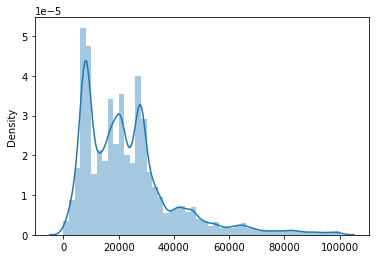

In [23]:
#Vermutung das medians normalverteilt sind 
import itertools
import seaborn as sns;
from numpy import inf
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import mielke
allFeesChained = sorted(list(itertools.chain.from_iterable(allFees)))
sns.distplot(allFeesChained[:-5000])

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='Density'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='Density'>

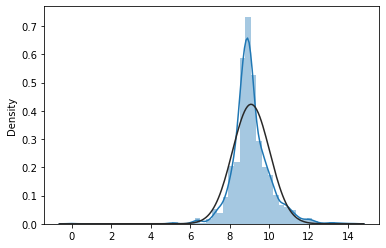

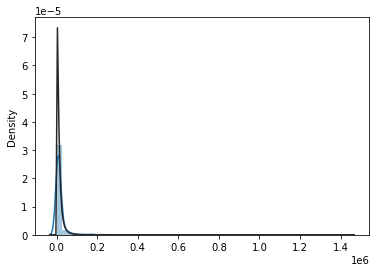

In [24]:
#n = 7
n = 30
#plt.hist(sorted([i.fee for i in blocks[n].transactions])[:len(blocks[n].transactions)-50])
import seaborn as sns;
from numpy import inf
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import mielke
#multipleBlocks1 = [i.fee for i in blocks[1].transactions]
#multipleBlocks2 = [i.fee for i in blocks[2].transactions]
#multipleBlocks3 = [i.fee for i in blocks[3].transactions]
#multipleBlocks4 = [i.fee for i in blocks[4].transactions]
#multipleBlocks5 = [i.fee for i in blocks[5].transactions]
#mbks = [multipleBlocks1,multipleBlocks5,multipleBlocks2,multipleBlocks3,multipleBlocks4]
#multiBlock=sorted(list(itertools.chain.from_iterable(mbks)))
#lnmb = np.log(multiBlock)
#lnmb[lnmb == inf] = 0
#lnmb[lnmb == -inf] = 0

txsData = sorted([i.fee for i in blocks[n].transactions])[:];
txsDataLog = np.log(txsData)

txsDataLog[txsDataLog == -inf] = 0
txsDataLog[txsDataLog == inf] = 0
#öognormalverteilung
plt.figure()
sns.distplot(txsDataLog[:],fit=norm)
plt.figure()
sns.distplot(txsData, fit=lognorm)

In [ ]:
#import csv

#with open('transactions.csv', mode='w') as employee_file:
    #employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    #employee_writer.writerow(['John Smith', 'Accounting', 'November'])